This is a quick inspection of RTP-007 (E2V) and RTM-011 (ITL) with respect to serial hysteresis, which potentially includes "classical" CTI short trapping as well as a longer decay signal, under the assumption that the latter is due to amplifier effects.  First we're going to look at the difference of the total effect between high level (70k ADU), low level (24k ADU), and bias frames.

The notebook was run on 2018_45 on 2018-11-14.

First we import stuff and setup some params.

In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

Check that obs_lsst is properly setup in the nb environment. If the following cell raises an exception, see the instructions in `examples/welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

If we want to look at the pixel images, we load firefly.  

In [4]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

Identify RTM-007 (E2V) or RTM-011 (ITL) repo and point the butler to it.

In [148]:
#BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-011/'
butler = Butler(BOOTCAMP_REPO_DIR)

Using the superflats, find the proper visit numbers for high, low, bias.

In [214]:
#for example E2V run
#longexposurevisits = butler.queryMetadata('raw', ['visit'], dataId={'testType': 'SFLAT_500', 'exptime': 33.746})
#shortexposurevisits = butler.queryMetadata('raw', ['visit'], dataId={'testType': 'SFLAT_500', 'exptime': 0.677})
#biasvisits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'BIAS', 'testType': 'SFLAT'})
# for example ITL run
longexposurevisits = butler.queryMetadata('raw', ['visit'], dataId={'testType': 'SFLAT_500', 'exptime': 148.766})
shortexposurevisits = butler.queryMetadata('raw', ['visit'], dataId={'testType': 'SFLAT_500', 'exptime': 3.112})
biasvisits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'BIAS', 'testType': 'SFLAT'})

Line below is exploring what is available via the metadata in the butler db.

In [215]:
#print("Available visits: %s" % ("".join(str(butler.queryMetadata('raw', ['run','visit','testType','imageType','wavelength','exptime']))))) 

Now here we get the first raw (high level) exposure, looking at the central sensor, and get that image.

In [234]:
dId=dict(visit=longexposurevisits[0],detectorName='S11')
ref = butler.dataRef("raw",**dId)
raw = ref.get('raw')

In [235]:
detector = raw.getDetector()

If one wishes, you can display the pixels.

In [236]:
#afw_display.mtv(raw)

This defines the flipping of electronics to detector coordinates.  Note that afw_display takes care of this for display purposes (previous line).

In [237]:
# for the geometry we've chosen, the y=0 amps are in the top
# Normally the read corner would tell you this, but there is currently a bug
# this is e2v only
#flipXY = {'C00':(False, True),
#          'C01':(False, True),
#          'C02':(False, True),
#          'C03':(False, True),
#          'C04':(False, True),
#          'C05':(False, True),
#          'C06':(False, True),
#          'C07':(False, True),
#          'C10':(True, False),
#          'C11':(True, False),
#          'C12':(True, False),
#          'C13':(True, False),
#          'C14':(True, False),
#          'C15':(True, False),
#          'C16':(True, False),
#          'C17':(True, False)}
# this is for ITL only (according to policy/lsstCam.yaml)
#flipXY = {'C00':(True, True),
#          'C01':(True, True),
#          'C02':(True, True),
#          'C03':(True, True),
#          'C04':(True, True),
#          'C05':(True, True),
#          'C06':(True, True),
#          'C07':(True, True),
#          'C10':(True, False),
#          'C11':(True, False),
#          'C12':(True, False),
#          'C13':(True, False),
#          'C14':(True, False),
#          'C15':(True, False),
#          'C16':(True, False),
#          'C17':(True, False)}
# for testing, just look at the C12 amplifier
flipXY = {'C12':(True, False)}


Get the real detector amp pixels (no overscan), detector amp pixels (with overscan), and overscan only pixels.

In [238]:
allpixels = {}
detectorpixels = {}
overscanpixels = {}
for key, value in flipXY.items():
        detbbox = detector[key].getBBox()
        allbbox = detector[key].getRawBBox()
        overscanbbox = detector[key].getRawHorizontalOverscanBBox()
        detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
        allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
        overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

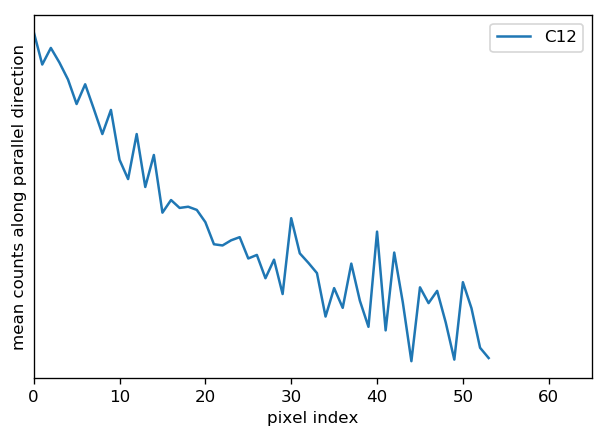

In [239]:
for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
    detarr = detectorpixels[channel_name].getArray() # pull out numpy array
    allarr = allpixels[channel_name].getArray() # pull out numpy array
    overscanarr = overscanpixels[channel_name].getArray() # pull out numpy array
    fx, fy = flips
    if fx:
        detarr = numpy.flip(detarr, axis=1)
        allarr = numpy.flip(allarr, axis=1)
        overscanarr = numpy.flip(overscanarr, axis=1)
    if fy:
        detarr = numpy.flip(detarr, axis=0)
        allarr = numpy.flip(allarr, axis=0)
        overscanarr = numpy.flip(overscanarr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    overscanmean = numpy.mean(overscanarr, axis=0)
    allmean = numpy.mean(allarr, axis=0)
    # get the mean level in the detector
    detmean = numpy.mean(detarr)
    longcti=overscanmean/detmean
    plt.semilogy(overscanmean/detmean, label=channel_name)
plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(0, 65)
#plt.ylim(0.4,0.5)
plt.legend()


In [240]:
# for low flux
dId=dict(visit=shortexposurevisits[0],detectorName='S11')
ref = butler.dataRef("raw",**dId)
raw = ref.get('raw')

In [241]:
detector = raw.getDetector()

In [242]:
allpixels = {}
detectorpixels = {}
overscanpixels = {}
for key, value in flipXY.items():
        detbbox = detector[key].getBBox()
        allbbox = detector[key].getRawBBox()
        overscanbbox = detector[key].getRawHorizontalOverscanBBox()
        detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
        allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
        overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

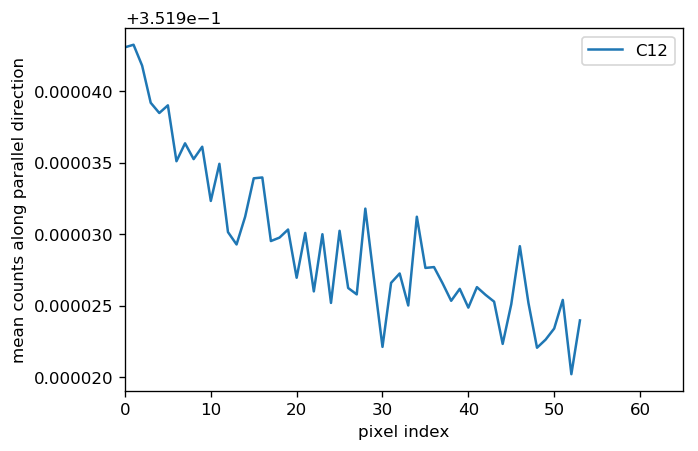

In [255]:
for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
    detarr = detectorpixels[channel_name].getArray() # pull out numpy array
    allarr = allpixels[channel_name].getArray() # pull out numpy array
    overscanarr = overscanpixels[channel_name].getArray() # pull out numpy array
    fx, fy = flips
    if fx:
        detarr = numpy.flip(detarr, axis=1)
        allarr = numpy.flip(allarr, axis=1)
        overscanarr = numpy.flip(overscanarr, axis=1)
    if fy:
        detarr = numpy.flip(detarr, axis=0)
        allarr = numpy.flip(allarr, axis=0)
        overscanarr = numpy.flip(overscanarr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    overscanmean = numpy.mean(overscanarr, axis=0)
    # get the mean level in the detector
    detmean = numpy.mean(detarr)
#    plt.semilogy((overscanmean/detmean), label=channel_name)
# if we want the ratio high flux/low flux:    
    plt.plot(longcti/(overscanmean/detmean), label=channel_name)

plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(0, 65)
plt.legend()

In [228]:
# for bias
dId=dict(visit=biasvisits[0],detectorName='S11')
ref = butler.dataRef("raw",**dId)
raw = ref.get('raw')

In [229]:
detector = raw.getDetector()

In [230]:
allpixels = {}
detectorpixels = {}
overscanpixels = {}
for key, value in flipXY.items():
        detbbox = detector[key].getBBox()
        allbbox = detector[key].getRawBBox()
        overscanbbox = detector[key].getRawHorizontalOverscanBBox()
        detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
        allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
        overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()

0.9887722


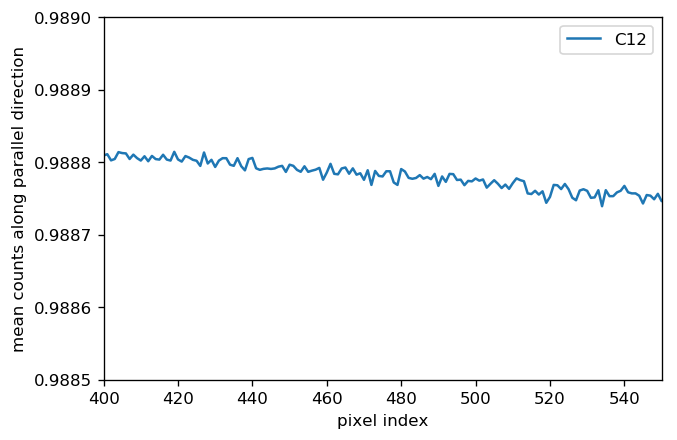

In [268]:
for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
    detarr = detectorpixels[channel_name].getArray() # pull out numpy array
    allarr = allpixels[channel_name].getArray() # pull out numpy array
    overscanarr = overscanpixels[channel_name].getArray() # pull out numpy array
    fx, fy = flips
    if fx:
        detarr = numpy.flip(detarr, axis=1)
        allarr = numpy.flip(allarr, axis=1)
        overscanarr = numpy.flip(overscanarr, axis=1)
    if fy:
        detarr = numpy.flip(detarr, axis=0)
        allarr = numpy.flip(allarr, axis=0)
        overscanarr = numpy.flip(overscanarr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    allmean = numpy.mean(allarr, axis=0)
    # get the mean level in the detector
    detmean = numpy.mean(detarr)
    plt.plot(allmean/detmean, label=channel_name)

plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(400,550)
plt.ylim(0.9885,0.989)
plt.legend()
print(numpy.max(overscanmean/detmean))

okay, let's try to sum these to get better SNR.

now iterate over all of the visits and take mean

0
1
2
3
4
5
6
7
8
9
708636.75
236525.88
0.3337759


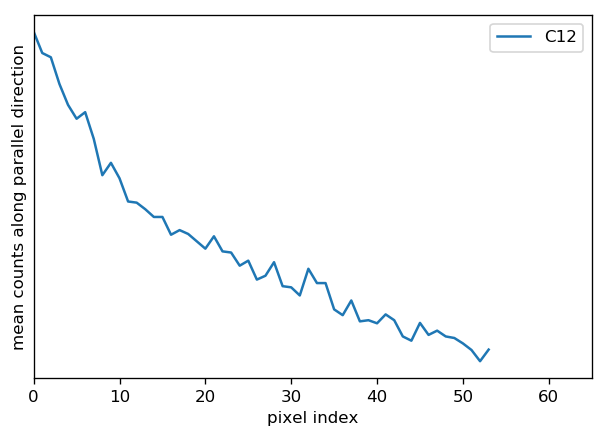

In [278]:
for visitcounter in range(len(longexposurevisits)):
    print(visitcounter)
    dId=dict(visit=longexposurevisits[visitcounter],detectorName='S11')
    ref = butler.dataRef("raw",**dId)
    raw = ref.get('raw')
    detector = raw.getDetector()
    allpixels = {}
    detectorpixels = {}
    overscanpixels = {}
    for key, value in flipXY.items():
            detbbox = detector[key].getBBox()
            allbbox = detector[key].getRawBBox()
            overscanbbox = detector[key].getRawHorizontalOverscanBBox()
            detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
            allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
            overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()
            
    for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
        detarr = detectorpixels[channel_name].getArray() # pull out numpy array
        allarr = allpixels[channel_name].getArray() # pull out numpy array
        overscanarr = overscanpixels[channel_name].getArray() # pull out numpy array
        fx, fy = flips
        if fx:
            detarr = numpy.flip(detarr, axis=1)
            allarr = numpy.flip(allarr, axis=1)
            overscanarr = numpy.flip(overscanarr, axis=1)
        if fy:
            detarr = numpy.flip(detarr, axis=0)
            allarr = numpy.flip(allarr, axis=0)
            overscanarr = numpy.flip(overscanarr, axis=0)
        if visitcounter==0:
            sumdetarr=detarr.copy()
            sumallarr=allarr.copy()
            sumoverscanarr=overscanarr.copy()
        if visitcounter!=0:
            sumdetarr+=detarr
            sumallarr+=allarr
            sumoverscanarr+=overscanarr
for channel_name, flips in flipXY.items():
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    overscanmean = numpy.mean(sumoverscanarr, axis=0)
    # get the mean level in the detector
    detmean = numpy.mean(sumdetarr)
    longcti=overscanmean/detmean
    plt.semilogy(overscanmean/detmean, label=channel_name)
print(detmean)
print(numpy.max(overscanmean))
print(numpy.max(overscanmean/detmean))
plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(0, 65)
#plt.ylim(-0.5, 0.5)
plt.legend()

for low flux:

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0.35129514


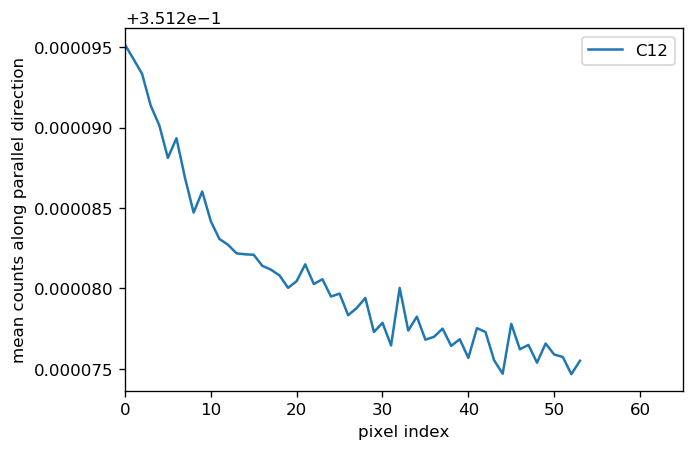

In [254]:
for visitcounter in range(len(shortexposurevisits)):
    print(visitcounter)
    dId=dict(visit=shortexposurevisits[visitcounter],detectorName='S11')
    ref = butler.dataRef("raw",**dId)
    raw = ref.get('raw')
    detector = raw.getDetector()
    allpixels = {}
    detectorpixels = {}
    overscanpixels = {}
    for key, value in flipXY.items():
            detbbox = detector[key].getBBox()
            allbbox = detector[key].getRawBBox()
            overscanbbox = detector[key].getRawHorizontalOverscanBBox()
            detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
            allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
            overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()
            
    for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
        detarr = detectorpixels[channel_name].getArray() # pull out numpy array
        allarr = allpixels[channel_name].getArray() # pull out numpy array
        overscanarr = overscanpixels[channel_name].getArray() # pull out numpy array
        fx, fy = flips
        if fx:
            detarr = numpy.flip(detarr, axis=1)
            allarr = numpy.flip(allarr, axis=1)
            overscanarr = numpy.flip(overscanarr, axis=1)
        if fy:
            detarr = numpy.flip(detarr, axis=0)
            allarr = numpy.flip(allarr, axis=0)
            overscanarr = numpy.flip(overscanarr, axis=0)
        if visitcounter==0:
            sumdetarr=detarr.copy()
            sumallarr=allarr.copy()
            sumoverscanarr=overscanarr.copy()
        if visitcounter!=0:
            sumdetarr+=detarr
            sumallarr+=allarr
            sumoverscanarr+=overscanarr
for channel_name, flips in flipXY.items():
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    overscanmean = numpy.mean(sumoverscanarr, axis=0)
    # get the mean level in the detector
    detmean = numpy.mean(sumdetarr)
#    plt.semilogy((overscanmean/detmean), label=channel_name)
# if we want to take the ratio high flux/low flux:    
    plt.plot(longcti/(overscanmean/detmean), label=channel_name)

print(numpy.max(longcti/(overscanmean/detmean)))
plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(0, 65)
#plt.ylim(-0.5, 0.5)
plt.legend()

for bias exposures:

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
1.0648798
0.98783123


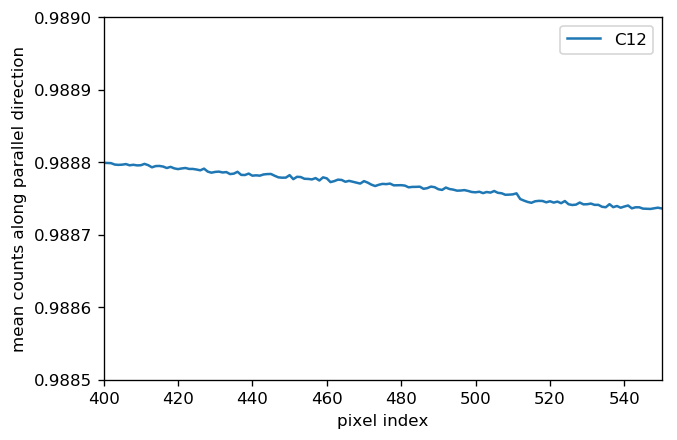

In [276]:
for visitcounter in range(len(biasvisits)):
    print(visitcounter)
    dId=dict(visit=biasvisits[visitcounter],detectorName='S11')
    ref = butler.dataRef("raw",**dId)
    raw = ref.get('raw')
    detector = raw.getDetector()
    allpixels = {}
    detectorpixels = {}
    overscanpixels = {}
    for key, value in flipXY.items():
            detbbox = detector[key].getBBox()
            allbbox = detector[key].getRawBBox()
            overscanbbox = detector[key].getRawHorizontalOverscanBBox()
            detectorpixels[key] = raw[detbbox].getMaskedImage().getImage().clone()
            allpixels[key] = raw[allbbox].getMaskedImage().getImage().clone()
            overscanpixels[key] = raw[overscanbbox].getMaskedImage().getImage().clone()
            
    for channel_name, flips in flipXY.items():
    # get all the amps in the same orientation and plot the mean along the y-axis
        detarr = detectorpixels[channel_name].getArray() # pull out numpy array
        allarr = allpixels[channel_name].getArray() # pull out numpy array
        overscanarr = overscanpixels[channel_name].getArray() # pull out numpy array
        fx, fy = flips
        if fx:
            detarr = numpy.flip(detarr, axis=1)
            allarr = numpy.flip(allarr, axis=1)
            overscanarr = numpy.flip(overscanarr, axis=1)
        if fy:
            detarr = numpy.flip(detarr, axis=0)
            allarr = numpy.flip(allarr, axis=0)
            overscanarr = numpy.flip(overscanarr, axis=0)
        if visitcounter==0:
            sumdetarr=detarr.copy()
            sumallarr=allarr.copy()
            sumoverscanarr=overscanarr.copy()
        if visitcounter!=0:
            sumdetarr+=detarr
            sumallarr+=allarr
            sumoverscanarr+=overscanarr
for channel_name, flips in flipXY.items():
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    allmean = numpy.mean(sumallarr, axis=0)
    # get the mean level in the detector
    detmean = numpy.mean(sumdetarr)
    plt.plot(allmean/detmean, label=channel_name)

print(numpy.max(allmean/detmean))
print(numpy.min(allmean/detmean))
plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(400,550)
plt.ylim(0.9885,0.989)
plt.legend()

We concur that there is at least two components to the deffered charge with different timescales.  We also think that we're seeing an flux dependence in the bias.